The following code downloads the dataset and prepares the data for 10 fold cross validation
No need to run them 
Check the data_folds directory

In [2]:
import gdown
import h5py
import numpy as np
import os
from tqdm import tqdm
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
file_id = '1IxN2sX2TX0uK6CFDh8eudb8haz3RlF7X'
download_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'data.hdf5'

gdown.download(download_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1IxN2sX2TX0uK6CFDh8eudb8haz3RlF7X
From (redirected): https://drive.google.com/uc?id=1IxN2sX2TX0uK6CFDh8eudb8haz3RlF7X&confirm=t&uuid=53dca239-f564-4c48-a2ee-db84af3f8381
To: C:\Users\aruzhan.suleimenova\Desktop\jupyter_notes\data.hdf5
100%|█████████████████████████████████████████████████████████████████████████████| 2.55G/2.55G [03:11<00:00, 13.3MB/s]


'data.hdf5'

In [4]:
import h5py

# Load the HDF5 file
file_path = 'data.hdf5'
with h5py.File(file_path, 'r') as f:
    # List all groups and datasets within the file
    print("Keys in 'data.hdf5':")
    print(list(f.keys()))

    # Assuming there's a dataset named 'data' containing all samples
    dataset = f['data']

    # Check the shape of the dataset to understand its size
    print("Shape of 'data' dataset:", dataset.shape)

Keys in 'data.hdf5':
['data']
Shape of 'data' dataset: (127260, 2, 1250)


In [6]:
fl = h5py.File(file_path, 'r')
data_length = len(fl['data'])
fl.close()
data_length

127260

In [4]:
!mkdir data_folds

In [73]:
import h5py
import numpy as np
import os
from tqdm import tqdm
import pickle

def fold_data():
    length = 1250  # length of the signals

    # Starting points of validation data for 5 folds
    validation_data_start = {
        0: 40000,
        1: 0,
        2: 10000,
        3: 20000,
        4: 30000,
    }

    # Load the episode data once
    fl = h5py.File('data.hdf5', 'r')
    data = fl['data'][:50000]

    for fold_id in tqdm(range(5), desc='Folding Data'):  # Iterate for 5 folds
        X_train = []  # Initialize train data
        Y_train = []

        X_val = []  # Initialize validation data
        Y_val = []

        max_ppg = -10000  # Initialize metadata for min-max of abp, ppg signals
        min_ppg = 10000
        max_abp = -10000
        min_abp = 10000

        val_start = validation_data_start[fold_id]  # Validation data start
        val_end = val_start + 10000  # Validation data end

        # Process training data before validation samples
        for i in tqdm(range(0, val_start), desc='Training Data Part 1'):
            sample = data[i]
            X_train.append(sample[1][:length].reshape(length, 1))  # ppg signal
            Y_train.append(sample[0][:length].reshape(length, 1))  # abp signal
            max_ppg = max(np.max(sample[1]), max_ppg)
            min_ppg = min(np.min(sample[1]), min_ppg)
            max_abp = max(np.max(sample[0]), max_abp)
            min_abp = min(np.min(sample[0]), min_abp)

        # Process training data after validation samples
        for i in tqdm(range(val_end, 50000), desc='Training Data Part 2'):
            sample = data[i]
            X_train.append(sample[1][:length].reshape(length, 1))  # ppg signal
            Y_train.append(sample[0][:length].reshape(length, 1))  # abp signal
            max_ppg = max(np.max(sample[1]), max_ppg)
            min_ppg = min(np.min(sample[1]), min_ppg)
            max_abp = max(np.max(sample[0]), max_abp)
            min_abp = min(np.min(sample[0]), min_abp)

        # Process validation data
        for i in tqdm(range(val_start, val_end), desc='Validation Data'):
            sample = data[i]
            X_val.append(sample[1][:length].reshape(length, 1))  # ppg signal
            Y_val.append(sample[0][:length].reshape(length, 1))  # abp signal
            max_ppg = max(np.max(sample[1]), max_ppg)
            min_ppg = min(np.min(sample[1]), min_ppg)
            max_abp = max(np.max(sample[0]), max_abp)
            min_abp = min(np.min(sample[0]), min_abp)

        # Convert lists to numpy arrays for efficiency
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        X_val = np.array(X_val)
        Y_val = np.array(Y_val)

        # Normalize training and validation data
        X_train = (X_train - min_ppg) / (max_ppg - min_ppg)
        Y_train = (Y_train - min_abp) / (max_abp - min_abp)
        X_val = (X_val - min_ppg) / (max_ppg - min_ppg)
        Y_val = (Y_val - min_abp) / (max_abp - min_abp)

        # Save training and validation data splits
        os.makedirs('data_folds', exist_ok=True)
        with open(f'data_folds/train{fold_id}.p', 'wb') as f:
            pickle.dump({'X_train': X_train, 'Y_train': Y_train}, f)
        with open(f'data_folds/val{fold_id}.p', 'wb') as f:
            pickle.dump({'X_val': X_val, 'Y_val': Y_val}, f)

        # Save metadata
        with open(f'data_folds/meta{fold_id}.p', 'wb') as f:
            pickle.dump({'max_ppg': max_ppg, 'min_ppg': min_ppg,
                         'max_abp': max_abp, 'min_abp': min_abp}, f)

    # Process test data
    fl = h5py.File('data.hdf5', 'r')
    test_data = fl['data'][50000:60000]
    X_test = []
    Y_test = []

    for sample in tqdm(test_data, desc='Test Data'):
        X_test.append(sample[1][:length].reshape(length, 1))  # ppg signal
        Y_test.append(sample[0][:length].reshape(length, 1))  # abp signal

    fl.close()  # Close the HDF5 file

    # Convert test data to numpy arrays
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    # Normalize test data
    X_test = (X_test - min_ppg) / (max_ppg - min_ppg)
    Y_test = (Y_test - min_abp) / (max_abp - min_abp)

    # Save test data split
    with open('data_folds/test.p', 'wb') as f:
        pickle.dump({'X_test': X_test, 'Y_test': Y_test}, f)

def main():
    fold_data()  # Split the data for 5-fold cross-validation

if __name__ == '__main__':
    main()


Training Data Part 1: 100%|███████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 64412.63it/s]

Training Data Part 2: 0it [00:00, ?it/s]

Folding Data:  20%|██████████████                                                        | 1/5 [00:01<00:06,  1.74s/it]
Training Data Part 1: 0it [00:00, ?it/s]

Training Data Part 2: 100%|███████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 64128.92it/s]

Training Data Part 1: 100%|███████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 62082.56it/s]

Training Data Part 2: 100%|███████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 62696.16it/s]

Training Data Part 1: 100%|███████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 62728.98it/s]

Training Data Part 2: 100%|███████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 62497.82it/s]

Training Data Part 1: 100%|███████████████████████████████████████████

In [47]:
file_id = '1HhcOzLbZgxOS5byOJF43r4veGWsQVb8M'
download_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'data_folds/meta.p'

gdown.download(download_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1HhcOzLbZgxOS5byOJF43r4veGWsQVb8M
To: C:\Users\aruzhan.suleimenova\Desktop\jupyter_notes\data_folds\meta.p
100%|███████████████████████████████████████████████████████████████████████████████| 54.0/54.0 [00:00<00:00, 3.53kB/s]


'data_folds/meta.p'

In [4]:
file_path = 'data_folds/'

In [6]:
with open(file_path + 'meta.p', 'rb') as f:
    data = pickle.load(f)
    
data

{'max_abp': 178.8, 'min_abp': 60.2}

In [8]:
file_path = 'data_folds/meta0.p'
with open(file_path, 'rb') as f:
        data = pickle.load(f)

print(data.keys())

print(data['max_ppg'])
print(data['min_ppg'])
print(data['max_abp'])
print(data['min_abp'])


dict_keys(['max_ppg', 'min_ppg', 'max_abp', 'min_abp'])
4.001955034213099
0.0
199.9479008990615
50.0


In [10]:
file_path = 'data_folds/train0.p'
with open(file_path, 'rb') as f:
        data0 = pickle.load(f)

print(data0.keys())
print(data0['X_train'].shape)
print(data0['X_train'][0])

dict_keys(['X_train', 'Y_train'])
(40000, 1250, 1)
[[0.30581339]
 [0.30434783]
 [0.30385931]
 ...
 [0.31802638]
 [0.3197362 ]
 [0.32071324]]


In [12]:
file_path = 'data_folds/train3.p'
with open(file_path, 'rb') as f:
        data = pickle.load(f)

print(data.keys())
print(data['X_train'].shape)
print(data['X_train'][0])


dict_keys(['X_train', 'Y_train'])
(40000, 1250, 1)
[[0.30581339]
 [0.30434783]
 [0.30385931]
 ...
 [0.31802638]
 [0.3197362 ]
 [0.32071324]]


In [14]:
import torch
import torch.nn as nn


class IncBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size = 15, stride = 1, padding = 7):
        super(IncBlock,self).__init__()

        self.conv1x1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias = False)

        self.conv1 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = size, stride = stride, padding = padding ),
                                   nn.BatchNorm1d(out_channels//4))

        self.conv2 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = 1, bias = False),
                                   nn.BatchNorm1d(out_channels//4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels//4, out_channels//4, kernel_size = size +2 , stride = stride, padding = padding + 1),
                                   nn.BatchNorm1d(out_channels//4))

        self.conv3 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = 1, bias = False),
                                   nn.BatchNorm1d(out_channels//4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels//4, out_channels//4, kernel_size = size + 4 , stride = stride, padding = padding + 2),
                                   nn.BatchNorm1d(out_channels//4))


        self.conv4 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = 1, bias = False),
                                   nn.BatchNorm1d(out_channels//4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels//4, out_channels//4, kernel_size = size + 6 , stride = stride, padding = padding + 3),
                                   nn.BatchNorm1d(out_channels//4))
        self.relu = nn.ReLU()
    def forward(self,x):
        res = self.conv1x1(x)
#         print (res.size())


        c1 = self.conv1(x)
#         print (c1.size())

        c2 = self.conv2(x)
#         print (c2.size())

        c3 = self.conv3(x)
#         print (c3.size())

        c4 = self.conv4(x)
#         print (c4.size())

        concat = torch.cat((c1,c2,c3,c4),dim = 1)

        concat+=res
#         print (concat.shape)
        return self.relu(concat)




class InterAxialBlock(nn.Module):
        #3
  def __init__(self,in_channels = 1, out_channels = 1):

    super(InterAxialBlock, self).__init__()

    self.conv1 = nn.Conv1d(in_channels,8,3)
    self.bn1 = nn.BatchNorm1d(8)

    self.conv2 = nn.Conv1d(8,16,3)
    self.bn2 =nn.BatchNorm1d(16)

    self.conv3 = nn.Conv2d(1,1,(3,3), 2)
    self.bn3 = nn.BatchNorm2d(1)

    self.conv4 = nn.Conv2d(1, 1, (3,15), padding = (0,7))
    self.bn4 = nn.BatchNorm2d(1)

    self.conv5 = nn.Conv1d(1,out_channels,3, padding = 1)
    self.bn5 = nn.BatchNorm1d(out_channels)
    self.relu1 = nn.LeakyReLU(0.2)


    self.mp1 = nn.MaxPool1d(2)
    self.mp2 = nn.MaxPool2d((2,2))




  def forward(self, x):

#     print("in Inter",x.shape)
    x = self.relu1(self.bn1(self.conv1(x)))

    x = self.relu1(self.bn2(self.conv2(x)))
#3d -> 4d
    x = x.view(x.shape[0],1,x.shape[1],x.shape[2])

    x = self.relu1(self.bn3(self.conv3(x)))

    x = self.mp2(x)


    x = self.relu1(self.bn4(self.conv4(x)))


    x = torch.squeeze(x, dim = 1)
    x = self.relu1(self.bn5(self.conv5(x)))


    return x

class Unet(nn.Module):
    def __init__(self, shape):
        super(Unet, self).__init__()
        #1
        in_channels = 1

        self.inter = nn.Sequential(InterAxialBlock())

        self.en1 = nn.Sequential(nn.Conv1d(in_channels, 32, 3, padding = 1),
                                nn.BatchNorm1d(32),
                                nn.LeakyReLU(0.2),
                                nn.Conv1d(32, 32, 5, stride = 2, padding = 2),
                                IncBlock(32,32))

        self.en2 = nn.Sequential(nn.Conv1d(32, 64, 3, padding = 1),
                                nn.BatchNorm1d(64),
                                nn.LeakyReLU(0.2),
                                 nn.Conv1d(64, 64, 5, stride = 2, padding = 2),
                                IncBlock(64,64))


        self.en3 = nn.Sequential(nn.Conv1d(64,128, 3, padding = 1),
                                 nn.BatchNorm1d(128),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv1d(128, 128, 3, stride = 2, padding = 1),
                                IncBlock(128,128))

        self.en4 = nn.Sequential(nn.Conv1d(128,256, 3,padding = 1),
                                 nn.BatchNorm1d(256),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv1d(256, 256, 5, stride = 2, padding = 1),
                                IncBlock(256,256))


        self.en5 = nn.Sequential(nn.Conv1d(256,512, 3, padding = 1),
                                 nn.BatchNorm1d(512),
                                 nn.LeakyReLU(0.2),
                                 IncBlock(512,512))


        self.de1 = nn.Sequential(nn.ConvTranspose1d(512,256,1),
                               nn.BatchNorm1d(256),
                               nn.LeakyReLU(0.2),
                                IncBlock(256,256))

        self.de2 =  nn.Sequential(nn.Conv1d(512,256,3, padding = 1),
                               nn.BatchNorm1d(256),
                               nn.LeakyReLU(0.2),
                                  nn.ConvTranspose1d(256,128,3, stride = 2),
                                IncBlock(128,128))

        self.de3 =  nn.Sequential(nn.Conv1d(256,128,3, stride = 1, padding = 1),
                               nn.BatchNorm1d(128),
                               nn.LeakyReLU(0.2),
                                nn.ConvTranspose1d(128,64,3, stride = 2),
                                IncBlock(64,64))

        self.de4 =  nn.Sequential(nn.Conv1d(128,64,3, stride = 1, padding = 1),
                               nn.BatchNorm1d(64),
                               nn.LeakyReLU(0.2),
                                nn.ConvTranspose1d(64,32,3, stride = 2),
                                IncBlock(32,32))

        self.de5 = nn.Sequential(nn.Conv1d(64,32,3, stride = 1, padding = 1),
                               nn.BatchNorm1d(32),
                               nn.LeakyReLU(0.2),
                                nn.ConvTranspose1d(32,16,3, stride = 2),
                                IncBlock(16,16))

        self.de6 = nn.Sequential(nn.ConvTranspose1d(16,8,2,stride =2),
                                nn.BatchNorm1d(8),
                                nn.LeakyReLU(0.2))

        self.de7 = nn.Sequential(nn.ConvTranspose1d(8,4,2,stride =2),
                                nn.BatchNorm1d(4),
                                nn.LeakyReLU(0.2))

        self.de8 = nn.Sequential(nn.ConvTranspose1d(4,2,1,stride =1),
                                nn.BatchNorm1d(2),
                                nn.LeakyReLU(0.2))

        self.de9 = nn.Sequential(nn.ConvTranspose1d(2,1,1,stride =1),
                                nn.BatchNorm1d(1),
                                nn.LeakyReLU(0.2))


    def forward(self,x):

#         print("Before inter ",x.shape)
        x = self.inter(x)
#         print(" After Inter",x.shape)

        x = nn.ConstantPad1d((1,1),0)(x)
#         print ("After ConstantPad1d",x.shape)
        e1 = self.en1(x)
#         print ("After e1 ",e1.shape)

        e2 = self.en2(e1)
#         print ("After e2 ",e2.shape)

        e3 = self.en3(e2)
#         print ("After e3 ",e3.shape)

        e4 = self.en4(e3)
#         print ("After e4  ",e4.shape)

        e5 = self.en5(e4)
#         print ("After e5 ",e5.shape)
#         print ("-----------------------------------------------------------------------------")
        d1 = self.de1(e5)
#         print ("After d1", d1.shape)

#         print("Before cat d1 e4 {} {}".format(d1.shape,e4.shape))
        cat = torch.cat([d1,e4],1)
#         print("After cat d1 e4 {}".format(cat.shape))

        d2 = self.de2(cat)
#         print ("After d2 ",d2.shape)

#         print ("Before cat d2 e3 {} {}  ".format(d2.shape,e3.shape))
        cat = torch.cat([d2,e3[:,:,:-1]],1)
#         print("After cat d2 e3 {}".format(cat.shape))



        d3 = self.de3(cat)

#         print ("After d3 ",d3.shape)
#         print ("Before cat d3 e2 {} {}  ".format(d3.shape,e2.shape))
#         print("-1 being done on d3")
        cat = torch.cat([d3,e2[:,:,:]],1) #MADE A CHANGE HERE, ADDED -1
#         print("After cat d3 e2 {}".format(cat.shape))

        d4 = self.de4(cat)
#         print ("After d4 ",d4.shape)

#         print ("Before cat d4 e1 {} {}  ".format(d4.shape,e1.shape))
        cat = torch.cat([d4[:,:,:-2],e1],1) #MADE A CHANGE HERE, ([d4[:,:,:-2],e1],1) this is the original one
#         print("After cat d4 e1 {}".format(cat.shape))

        d5 = self.de5(cat)[:,:,:-2]
#         print ("After d5 ", d5.shape)

        d6 = self.de6(d5)[:,:,:-1]

#         print(d6.shape)

        d7 = self.de7(d6)
#         print("d7 ", d7.shape)
        d8 = self.de8(d7)
#         print(d8.shape)
        d9 = self.de9(d8)
#         print(d9.shape)
        return d9

In [16]:
import torch

shape = (1,1,1250)
model = Unet(shape)

dummy_input = torch.randn(1,1,1250)
output = model(dummy_input)
print("Model output shape: ", output.shape) 

Model output shape:  torch.Size([1, 1, 1250])


In [18]:
import pickle
import os
import numpy as np
from torch.utils.data import Dataset

class BPdatasetv1(Dataset):
    def __init__(self, fold_num, train=False, val=False):
        if train:
            dt = pickle.load(open(os.path.join('data_folds', f'train{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_train'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['X_train'], 1, 2).astype('float32')
        elif val:
            dt = pickle.load(open(os.path.join('data_folds', f'val{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_val'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['X_val'], 1, 2).astype('float32')

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inp = self.input[idx]
        out = self.output[idx]
        return inp, out

class BPdatasetv2(Dataset):
    def __init__(self, fold_num, train=False, val=False, test=False):
        if train:
            dt = pickle.load(open(os.path.join('data_folds', f'train{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_train'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['Y_train'], 1, 2).astype('float32')
        elif val:
            dt = pickle.load(open(os.path.join('data_folds', f'val{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_val'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['Y_val'], 1, 2).astype('float32')
        elif test:
            dt = pickle.load(open(os.path.join('data_folds', 'test.p'), 'rb'))
            self.input = np.swapaxes(dt['X_test'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['Y_test'], 1, 2).astype('float32')

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inp = self.input[idx]
        out = self.output[idx]
        return inp, out


In [20]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=10):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [34]:
!mkdir model

A subdirectory or file model already exists.


In [36]:
import os
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader


bs = 256
length = 1250
epochs = 20
folds = 5

model = Unet((bs, 1, length)).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopper(patience=7, min_delta=0)

best_loss = 1000

start_time = time.time()
for epoch in range(epochs):
    model.train()
    print('Epoch {}/{}'.format(epoch + 1, epochs))

    running_loss = 0.0
    running_loss_v = 0.0

    for fold in range(1, folds + 1):
        train_loader = DataLoader(BPdatasetv1(fold-1, train=True), batch_size=bs, shuffle=True)
        val_loader = DataLoader(BPdatasetv1(fold-1, val=True), batch_size=bs, shuffle=False)

        for idx, (inputs, output) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.cuda()
            output = output.cuda()

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                pred = model(inputs)
                loss = criterion(pred, output)

            scaler.scale(loss).backward()
            running_loss += loss.item() * inputs.size(0)
            scaler.step(optimizer)
            scaler.update()

        scheduler.step()

        # VALIDATION
        model.eval()
        with torch.no_grad():
            for idx, (inputs_v, labels_v) in tqdm(enumerate(val_loader), total=len(val_loader)):
                inputs_v = inputs_v.cuda()
                labels_v = labels_v.cuda()
                outputs_v = model(inputs_v).cuda()
                loss_v = criterion(outputs_v, labels_v)
                running_loss_v += loss_v.item() * inputs_v.size(0)

    avg_train_loss = running_loss / (len(train_loader.dataset) * folds)
    avg_val_loss = running_loss_v / (len(val_loader.dataset) * folds)

    path = 'model/ssl.pt'

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_loss,
            'exp_dir': 'model'
        }, f=path)
    print('Loss: {:.4f}   Val_loss: {:.4f}'.format(avg_train_loss, avg_val_loss))

    if early_stopper.early_stop(avg_val_loss):
        print("Early stopping")
        break

end_time = time.time()
training_duration = end_time - start_time

hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training duration: {training_duration} seconds")
print(f"Training duration: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Epoch 1/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.81it/s]


Loss: 0.0280   Val_loss: 0.0364
Epoch 2/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.34it/s]


Loss: 0.0139   Val_loss: 0.0129
Epoch 3/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.99it/s]


Loss: 0.0117   Val_loss: 0.0159
Epoch 4/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.61it/s]


Loss: 0.0109   Val_loss: 0.0098
Epoch 5/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.43it/s]


Loss: 0.0096   Val_loss: 0.0089
Epoch 6/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.87it/s]


Loss: 0.0085   Val_loss: 0.0073
Epoch 7/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.15it/s]


Loss: 0.0081   Val_loss: 0.0086
Epoch 8/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.33it/s]


Loss: 0.0072   Val_loss: 0.0073
Epoch 9/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.71it/s]


Loss: 0.0066   Val_loss: 0.0071
Epoch 10/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.02it/s]


Loss: 0.0060   Val_loss: 0.0054
Epoch 11/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.83it/s]


Loss: 0.0053   Val_loss: 0.0048
Epoch 12/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.18it/s]


Loss: 0.0054   Val_loss: 0.0112
Epoch 13/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.28it/s]


Loss: 0.0043   Val_loss: 0.0040
Epoch 14/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.93it/s]


Loss: 0.0039   Val_loss: 0.0033
Epoch 15/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.04it/s]


Loss: 0.0033   Val_loss: 0.0027
Epoch 16/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.53it/s]


Loss: 0.0029   Val_loss: 0.0026
Epoch 17/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.74it/s]


Loss: 0.0025   Val_loss: 0.0023
Epoch 18/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.50it/s]


Loss: 0.0021   Val_loss: 0.0021
Epoch 19/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.05it/s]


Loss: 0.0023   Val_loss: 0.0017
Epoch 20/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.72it/s]


Loss: 0.0018   Val_loss: 0.0013
Epoch 21/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.90it/s]


Loss: 0.0019   Val_loss: 0.0010
Epoch 22/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.22it/s]


Loss: 0.0017   Val_loss: 0.0016
Epoch 23/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.44it/s]


Loss: 0.0017   Val_loss: 0.0016
Epoch 24/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.05it/s]


Loss: 0.0015   Val_loss: 0.0015
Epoch 25/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.34it/s]


Loss: 0.0015   Val_loss: 0.0014
Epoch 26/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.24it/s]


Loss: 0.0014   Val_loss: 0.0013
Epoch 27/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.24it/s]


Loss: 0.0013   Val_loss: 0.0013
Epoch 28/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.36it/s]

Loss: 0.0013   Val_loss: 0.0013
Early stopping


In [24]:
import os
import re
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import time

bs = 256
length = 1250
epochs = 50
folds = 5

train_losses = []
val_losses = []

# Initialize the model and load pretrained weights if available
model = Unet((bs, 1, length)).cuda()
path = 'model/ssl_hdf5.pt'  # Path to your pretrained model checkpoint
checkpoint = torch.load(path)
pretrained_dict = {k: v for k, v in checkpoint['model'].items() if re.search('^e|^i', k)}

model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopper(patience=7)  # Adjust patience according to your needs

best_loss = 1000


start_time = time.time()
for epoch in range(epochs):
    model.train()
    print('Epoch {}/{}'.format(epoch + 1, epochs))

    running_loss = 0.0
    running_loss_v = 0.0

    for fold in range(1, folds + 1):
        train_loader = DataLoader(BPdatasetv2(fold-1, train=True), batch_size=bs, shuffle=True)
        val_loader = DataLoader(BPdatasetv2(fold-1, val=True), batch_size=bs, shuffle=False)

        for idx, (inputs, output) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.cuda()
            output = output.cuda()

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                pred = model(inputs)
                loss = criterion(pred, output)

            scaler.scale(loss).backward()
            running_loss += loss.item() * inputs.size(0)
            scaler.step(optimizer)
            scaler.update()

        scheduler.step()

        # VALIDATION
        model.eval()
        with torch.no_grad():
            for idx, (inputs_v, labels_v) in tqdm(enumerate(val_loader), total=len(val_loader)):
                inputs_v = inputs_v.cuda()
                labels_v = labels_v.cuda()
                outputs_v = model(inputs_v).cuda()
                loss_v = criterion(outputs_v, labels_v)
                running_loss_v += loss_v.item() * inputs_v.size(0)

    avg_train_loss = running_loss / (len(train_loader.dataset) * folds)
    avg_val_loss = running_loss_v / (len(val_loader.dataset) * folds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    path = 'final_hdf5.pt'

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_loss,
            'exp_dir': 'model'
        }, f=path)
    print('Loss: {:.4f}   Val_loss: {:.4f}'.format(avg_train_loss, avg_val_loss))

    if early_stopper.early_stop(avg_val_loss):
        print("Early stopping")
        break

end_time = time.time()
training_duration = end_time - start_time

hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training duration: {training_duration} seconds")
print(f"Training duration: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Epoch 1/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.35it/s]


Loss: 0.0195   Val_loss: 0.0179
Epoch 2/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.17it/s]


Loss: 0.0145   Val_loss: 0.0122
Epoch 3/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.34it/s]


Loss: 0.0162   Val_loss: 0.0986
Epoch 4/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.89it/s]


Loss: 0.0157   Val_loss: 0.0134
Epoch 5/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.51it/s]


Loss: 0.0112   Val_loss: 0.0532
Epoch 6/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.13it/s]


Loss: 0.0118   Val_loss: 0.0088
Epoch 7/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.51it/s]


Loss: 0.0088   Val_loss: 0.0093
Epoch 8/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.58it/s]


Loss: 0.0082   Val_loss: 0.0084
Epoch 9/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.91it/s]


Loss: 0.0086   Val_loss: 0.0083
Epoch 10/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.63it/s]


Loss: 0.0073   Val_loss: 0.0070
Epoch 11/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.20it/s]


Loss: 0.0070   Val_loss: 0.0178
Epoch 12/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.28it/s]


Loss: 0.0079   Val_loss: 0.0069
Epoch 13/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.25it/s]


Loss: 0.0071   Val_loss: 0.0069
Epoch 14/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.37it/s]


Loss: 0.0075   Val_loss: 0.0067
Epoch 15/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.16it/s]


Loss: 0.0073   Val_loss: 0.0066
Epoch 16/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.14it/s]


Loss: 0.0069   Val_loss: 0.0075
Epoch 17/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.00it/s]


Loss: 0.0069   Val_loss: 0.0064
Epoch 18/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.93it/s]


Loss: 0.0065   Val_loss: 0.0060
Epoch 19/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.93it/s]


Loss: 0.0070   Val_loss: 0.0227
Epoch 20/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.32it/s]


Loss: 0.0074   Val_loss: 0.0069
Epoch 21/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.71it/s]


Loss: 0.0066   Val_loss: 0.0064
Epoch 22/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.89it/s]


Loss: 0.0065   Val_loss: 0.0070
Epoch 23/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.31it/s]


Loss: 0.0064   Val_loss: 0.0062
Epoch 24/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.65it/s]


Loss: 0.0064   Val_loss: 0.0069
Epoch 25/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.78it/s]


Loss: 0.0063   Val_loss: 0.0065
Epoch 26/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.04it/s]


Loss: 0.0062   Val_loss: 0.0066
Epoch 27/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.70it/s]


Loss: 0.0062   Val_loss: 0.0063
Epoch 28/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.07it/s]


Loss: 0.0061   Val_loss: 0.0067
Epoch 29/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.51it/s]


Loss: 0.0061   Val_loss: 0.0069
Epoch 30/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.49it/s]


Loss: 0.0061   Val_loss: 0.0069
Epoch 31/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.15it/s]


Loss: 0.0061   Val_loss: 0.0073
Epoch 32/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.94it/s]


Loss: 0.0060   Val_loss: 0.0068
Epoch 33/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.13it/s]


Loss: 0.0065   Val_loss: 0.0327
Epoch 34/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.30it/s]


Loss: 0.0062   Val_loss: 0.0061
Epoch 35/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.30it/s]


Loss: 0.0060   Val_loss: 0.0059
Epoch 36/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.20it/s]


Loss: 0.0060   Val_loss: 0.0062
Epoch 37/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.92it/s]


Loss: 0.0062   Val_loss: 0.0062
Epoch 38/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.42it/s]


Loss: 0.0060   Val_loss: 0.0076
Epoch 39/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.57it/s]


Loss: 0.0060   Val_loss: 0.0061
Epoch 40/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.99it/s]


Loss: 0.0059   Val_loss: 0.0063
Epoch 41/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.54it/s]


Loss: 0.0060   Val_loss: 0.0063
Epoch 42/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.55it/s]


Loss: 0.0061   Val_loss: 0.0068
Epoch 43/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.61it/s]


Loss: 0.0061   Val_loss: 0.0067
Epoch 44/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.87it/s]


Loss: 0.0060   Val_loss: 0.0063
Epoch 45/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.69it/s]


Loss: 0.0060   Val_loss: 0.0058
Epoch 46/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.26it/s]


Loss: 0.0060   Val_loss: 0.0067
Epoch 47/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.98it/s]


Loss: 0.0060   Val_loss: 0.0063
Epoch 48/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.86it/s]


Loss: 0.0060   Val_loss: 0.0068
Epoch 49/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.90it/s]


Loss: 0.0060   Val_loss: 0.0058
Epoch 50/50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.20it/s]

Loss: 0.0060   Val_loss: 0.0060
Training duration: 2276.5598335266113 seconds
Training duration: 0 hours, 37 minutes, 56.56 seconds


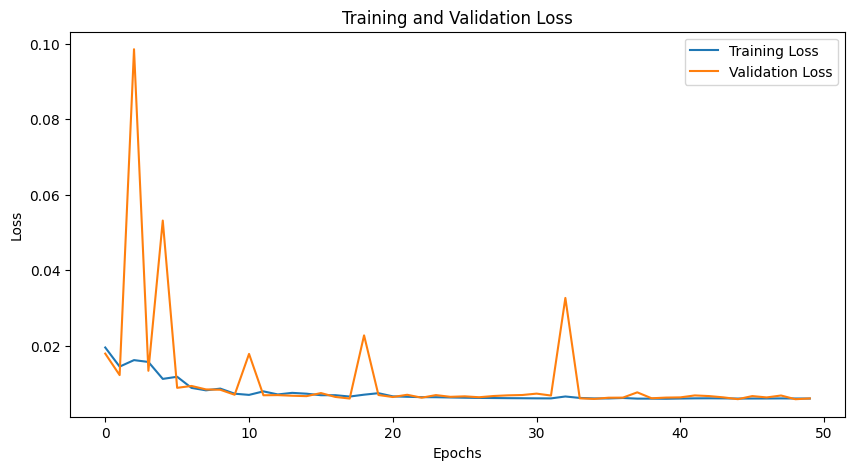

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [28]:
import pickle
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

import re

bs = 256

model = Unet((256,1,1250)).cuda()
path = 'final_hdf5.pt'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])

pick_path = 'output.p'

test = torch.utils.data.DataLoader(BPdatasetv2(0, train = False, val = False,  test = True), batch_size=bs)

temp1 = []
model.eval()
with torch.no_grad():
    for idx,(inputs,labels) in tqdm(enumerate(test),total=len(test),  disable=True):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs_v= model(inputs).cuda()

        temp1.extend(outputs_v)

temp1 = torch.stack(temp1)
with open(pick_path,'wb') as f:
    pickle.dump(temp1.cpu().detach().numpy(), f)

In [39]:
import pickle
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_BHS_Standard(filename):
    """
        Evaluates PPG2ABP based on
        BHS Standard Metric
    """

    def BHS_metric(err):
        """
        Computes the BHS Standard metric

        Arguments:
            err {array} -- array of absolute error

        Returns:
            tuple -- tuple of percentage of samples with <=5 mmHg, <=10 mmHg and <=15 mmHg error
        """

        leq5 = 0
        leq10 = 0
        leq15 = 0

        for i in range(len(err)):
            if abs(err[i]) <= 5:
                leq5 += 1
                leq10 += 1
                leq15 += 1
            elif abs(err[i]) <= 10:
                leq10 += 1
                leq15 += 1
            elif abs(err[i]) <= 15:
                leq15 += 1

        return (leq5 * 100.0 / len(err), leq10 * 100.0 / len(err), leq15 * 100.0 / len(err))

    def calcError(Ytrue, Ypred, max_abp, min_abp):
        """
        Calculates the absolute error of sbp, dbp, map etc.

        Arguments:
            Ytrue {array} -- ground truth
            Ypred {array} -- predicted
            max_abp {float} -- max value of abp signal
            min_abp {float} -- min value of abp signal

        Returns:
            tuple -- tuple of abs. errors of sbp, dbp and map calculation
        """

        sbps = []
        dbps = []
        maps = []

        for i in range(len(Ytrue)):
            y_t = Ytrue[i].ravel()
            y_p = Ypred[i].ravel()

            y_t = y_t * (max_abp - min_abp)
            y_p = y_p * (max_abp - min_abp)

            dbps.append(abs(min(y_t) - min(y_p)))
            sbps.append(abs(max(y_t) - max(y_p)))
            maps.append(abs(np.mean(y_t) - np.mean(y_p)))

        return (sbps, dbps, maps)

    dt = pickle.load(open(os.path.join('data_folds', 'test.p'), 'rb'))  # loading test data
    Y_test = dt['Y_test']

    dt = pickle.load(open('data_folds/meta.p', 'rb'))  # loading meta data
    max_abp = dt['max_abp']
    min_abp = dt['min_abp']

    Y_pred = pickle.load(open(filename, 'rb'))  # loading prediction

    (sbps, dbps, maps) = calcError(Y_test, Y_pred, max_abp, min_abp)  # compute errors

    sbp_percent = BHS_metric(sbps)  # compute BHS metric for sbp
    dbp_percent = BHS_metric(dbps)  # compute BHS metric for dbp
    map_percent = BHS_metric(maps)  # compute BHS metric for map

    print('----------------------------')
    print('|        BHS-Metric        |')
    print('----------------------------')

    print('----------------------------------------')
    print('|     | <= 5mmHg | <=10mmHg | <=15mmHg |')
    print('----------------------------------------')
    print('| DBP |  {} %  |  {} %  |  {} %  |'.format(round(dbp_percent[0], 2), round(dbp_percent[1], 2), round(dbp_percent[2], 2)))
    print('| MAP |  {} %  |  {} %  |  {} %  |'.format(round(map_percent[0], 2), round(map_percent[1], 2), round(map_percent[2], 2)))
    print('| SBP |  {} %  |  {} %  |  {} %  |'.format(round(sbp_percent[0], 2), round(sbp_percent[1], 2), round(sbp_percent[2], 2)))
    print('----------------------------------------')


def evaluate_AAMI_Standard(filename):
    """
        Evaluate PPG2ABP using AAMI Standard metric
    """

    def calcErrorAAMI(Ypred, Ytrue, max_abp, min_abp):
        """
        Calculates error of sbp, dbp, map for AAMI standard computation

        Arguments:
            Ytrue {array} -- ground truth
            Ypred {array} -- predicted
            max_abp {float} -- max value of abp signal
            min_abp {float} -- min value of abp signal

        Returns:
            tuple -- tuple of errors of sbp, dbp and map calculation
        """

        sbps = []
        dbps = []
        maps = []

        for i in range(len(Ytrue)):
            y_t = Ytrue[i].ravel()
            y_p = Ypred[i].ravel()

            y_t = y_t * (max_abp - min_abp)
            y_p = y_p * (max_abp - min_abp)

            dbps.append(min(y_p) - min(y_t))
            sbps.append(max(y_p) - max(y_t))
            maps.append(np.mean(y_p) - np.mean(y_t))

        return (sbps, dbps, maps)

    dt = pickle.load(open(os.path.join('data_folds', 'test.p'), 'rb'))  # loading test data
    Y_test = dt['Y_test']

    dt = pickle.load(open(os.path.join('data_folds', 'meta.p'), 'rb'))  # loading metadata
    max_abp = dt['max_abp']
    min_abp = dt['min_abp']

    Y_pred = pickle.load(open(filename, 'rb'))  # loading prediction

    (sbps, dbps, maps) = calcErrorAAMI(Y_test, Y_pred, max_abp, min_abp)  # compute error

    print('---------------------')
    print('|   AAMI Standard   |')
    print('---------------------')

    print('-----------------------')
    print('|     |  ME   |  STD  |')
    print('-----------------------')
    print('| DBP | {} | {} |'.format(round(np.mean(dbps), 3), round(np.std(dbps), 3)))
    print('| MAP | {} | {} |'.format(round(np.mean(maps), 3), round(np.std(maps), 3)))
    print('| SBP | {} | {} |'.format(round(np.mean(sbps), 3), round(np.std(sbps), 3)))
    print('-----------------------')


def evaluate_metrics(filename):
    def calcError(Ytrue, Ypred, max_abp, min_abp):
        sbp_t = []
        sbp_p = []
        dbp_t = []
        dbp_p = []
        map_t = []
        map_p = []

        for i in range(len(Ytrue)):
            y_t = Ytrue[i].ravel()
            y_p = Ypred[i].ravel()

            y_t = y_t * (max_abp - min_abp)
            y_p = y_p * (max_abp - min_abp)

            sbp_p.append(abs(max(y_p)))
            dbp_p.append(abs(min(y_p)))
            map_p.append(abs(np.mean(y_p)))
            sbp_t.append(abs(max(y_t)))
            dbp_t.append(abs(min(y_t)))
            map_t.append(abs(np.mean(y_t)))

        print("SBP")
        print("Mean Absolute Error : ", round(mean_absolute_error(sbp_t, sbp_p), 3))
        print("Root Mean Squared Error : ", round(mean_squared_error(sbp_t, sbp_p, squared=False), 3))
        print("R2 : ", r2_score(sbp_t, sbp_p))

        print("")

        print("DBP")
        print("Mean Absolute Error : ", round(mean_absolute_error(dbp_t, dbp_p), 3))
        print("Root Mean Squared Error : ", round(mean_squared_error(dbp_t, dbp_p, squared=False), 3))
        print("R2 : ", r2_score(dbp_t, dbp_p))

        print("")

        print("MAP")
        print("Mean Absolute Error : ", mean_absolute_error(map_t, map_p))
        print("Root Mean Squared Error : ", round(mean_squared_error(map_t, map_p, squared=False), 2))
        print("R2 : ", r2_score(map_t, map_p))

        print("------------------------------------------------------------------------")

    dt = pickle.load(open(os.path.join('data_folds', 'test.p'), 'rb'))  # loading test data
    Y_test = dt['Y_test']

    dt = pickle.load(open('data_folds/meta.p', 'rb'))  # loading meta data
    max_abp = dt['max_abp']
    min_abp = dt['min_abp']

    Y_pred = pickle.load(open(filename, 'rb'))  # loading prediction
    calcError(Y_test, Y_pred, max_abp, min_abp)


evaluate_BHS_Standard('output.p')
evaluate_AAMI_Standard('output.p')
evaluate_metrics('output.p')

----------------------------
|        BHS-Metric        |
----------------------------
----------------------------------------
|     | <= 5mmHg | <=10mmHg | <=15mmHg |
----------------------------------------
| DBP |  47.63 %  |  82.24 %  |  94.95 %  |
| MAP |  44.66 %  |  75.61 %  |  91.12 %  |
| SBP |  26.42 %  |  50.18 %  |  68.76 %  |
----------------------------------------
---------------------
|   AAMI Standard   |
---------------------
-----------------------
|     |  ME   |  STD  |
-----------------------
| DBP | -0.207 | 8.216 |
| MAP | -0.112 | 9.084 |
| SBP | 0.007 | 15.53 |
-----------------------
SBP
Mean Absolute Error :  12.176
Root Mean Squared Error :  15.53
R2 :  0.25115643940268895

DBP
Mean Absolute Error :  6.272
Root Mean Squared Error :  8.215
R2 :  0.15837304939427388

MAP
Mean Absolute Error :  6.978783846164958
Root Mean Squared Error :  9.08
R2 :  0.33439350276117696
------------------------------------------------------------------------
